# Простейшие нейронные сети на PyTorch

In [58]:
!pip install fastai --upgrade -q

In [59]:
!git clone https://github.com/RiskModellingResearch/DeepLearning_Autumn22.git

fatal: destination path 'DeepLearning_Winter22' already exists and is not an empty directory.


In [60]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.12.1+cu113


In [62]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [66]:
animals = pd.read_csv('./DeepLearning_Autumn22/week_01/data/animals.csv', sep='\t')

In [119]:
animals

,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,target
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,0,0,0,0,1,0,0,0,0,2
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,0,0,0,0,0,0,0,0,1,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,1,0,0,0,0,0,1,0,0,3
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,0,0,0,0,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,0,30.0,0,7,0.285871,1,0.034909,0.463624,1,1,...,1,0,0,0,0,1,0,0,0,3
26725,0,90.0,0,7,0.285871,0,0.061778,0.164522,1,1,...,0,0,0,0,1,0,0,0,0,3
26726,1,1460.0,1,4,0.001571,1,0.014587,0.374455,0,1,...,0,0,1,0,0,0,0,0,0,0
26727,0,28.0,0,7,0.285871,0,0.085505,0.199270,0,1,...,1,0,0,0,0,0,0,0,1,3


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [67]:
animals.target.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: target, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [68]:
animals.loc[animals.target == 'Died', 'target'] = 'Euthanasia'

Закодируем классы.

In [69]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
animals['target'] = le.fit_transform(animals['target'])
animals['target']

0        2
1        1
2        0
3        3
4        3
        ..
26724    3
26725    3
26726    0
26727    3
26728    3
Name: target, Length: 26729, dtype: int64

In [120]:
animals.target.value_counts()

0    10769
3     9422
2     4786
1     1752
Name: target, dtype: int64

In [70]:
len(animals['target'])

26729

In [71]:
animals.shape

(26729, 38)

Разобьём выборку на тренировочную и тестовую. 

In [72]:
X = animals.drop('target', axis=1)
y = animals['target']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить больших монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построим наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [74]:
from sklearn.metrics import log_loss

probas = np.array(y_train.value_counts(normalize=True).sort_index())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [75]:
# Посмотрим метрику на трейне и тесте
print(f'Train: {round(log_loss(y_train, np.tile(probas, X_train.shape[0]).reshape(-1, 4)), 4)}\nTest: {round(log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(-1, 4)), 4)}')

Train: 1.2205
Test: 1.2203


In [76]:
# Посмотрим точность на трейне и тесте
print(f'Train: {round(accuracy_score(y_train, np.tile(np.argmax(probas), X_train.shape[0])), 4)}\nTest: {round(accuracy_score(y_test, np.tile(np.argmax(probas), X_test.shape[0])), 4)}')

Train: 0.4029
Test: 0.4029


### Логистическая регрессия

In [77]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )

# Обучим на трейне
logreg.fit(X_train, y_train)

# Посмотрим метрику на трейне и тесте
print(f'Train: {round(log_loss(y_train, logreg.predict_proba(X_train)), 4)}\nTest: {round(log_loss(y_test, logreg.predict_proba(X_test)), 4)}')

Train: 1.0647
Test: 1.0691


In [78]:
np.argmax(logreg.predict_proba(X_train), axis=1)

array([3, 3, 0, ..., 3, 3, 0])

In [79]:
# Посмотрим точность на трейне и тесте
print(f'Train: {round(accuracy_score(y_train, np.argmax(logreg.predict_proba(X_train), axis=1)), 4)}\nTest: {round(accuracy_score(y_test, np.argmax(logreg.predict_proba(X_test), axis=1)), 4)}')

Train: 0.5527
Test: 0.5529


In [80]:
logreg.predict_proba(X_test) # 4 колонки, по одной на каждый класс

array([[0.18708765, 0.0670514 , 0.04653551, 0.69932544],
       [0.71548854, 0.02923199, 0.10843159, 0.14684789],
       [0.52375807, 0.03809741, 0.18069257, 0.25745195],
       ...,
       [0.77509781, 0.01024879, 0.17602537, 0.03862803],
       [0.22847272, 0.05773964, 0.03826507, 0.67552257],
       [0.66541118, 0.03011927, 0.12082774, 0.18364181]])

### Случайный лес 

In [81]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)

# Обучим на тесте
rf.fit(X_train, y_train)

# Посмотрим метрику на трейне и тесте
print(f'Train: {round(log_loss(y_train, rf.predict_proba(X_train)), 4)}\nTest: {round(log_loss(y_test, rf.predict_proba(X_test)), 4)}')

Train: 0.1817
Test: 0.7676


In [82]:
# Посмотрим точность на трейне и тесте
print(f'Train: {round(accuracy_score(y_train, np.argmax(rf.predict_proba(X_train), axis=1)), 4)}\nTest: {round(accuracy_score(y_test, np.argmax(rf.predict_proba(X_test), axis=1)), 4)}')

Train: 1.0
Test: 0.6912


Неплохой результат. Попробуем улучшить его с помощью нейросеток. 

## 2. Собираем свою нейросеть

# Пример библиотеки использования верхнеуровневого API

# FAST.AI

In [83]:
from fastai.tabular.all import *

Загрузим датасет, где необходимо предсказать, будет ли человек зарабатывать больше $50K в год.

In [84]:
cat_names = [
    'IsDog',
    'HasName',
    'MixColor',
    'TabbyColor',
    'MixBreed',
    'Domestic',
    'Shorthair',
    'Longhair',
    'Breed_Chihuahua Shorthair Mix',
    'Breed_Domestic Medium Hair Mix',
    'Breed_Domestic Shorthair Mix',
    'Breed_German Shepherd Mix',
    'Breed_Labrador Retriever Mix',
    'Breed_Pit Bull Mix',
    'Breed_Rare',
    'Sex_Female',
    'Sex_Male',
    'Sex_Unknown',
    'SexStatus_Flawed',
    'SexStatus_Intact',
    'SexStatus_Unknown',
    'Weekday_0',
    'Weekday_1',
    'Weekday_2',
    'Weekday_3',
    'Weekday_4',
    'Weekday_5',
    'Weekday_6'
]

In [85]:
cont_names = ['Age', 'ColorFreqAsIs', 'ColorFreqBase', 'Year', 'Month', 'Day', 'Hour']

In [86]:
splitter = IndexSplitter(X_train.index)
splits = splitter(animals)

In [87]:
tab_data = TabularPandas(animals,
                         procs=[Categorify, FillMissing, Normalize],
                         cat_names = cat_names,
                         cont_names = cont_names,
                         y_names='target',
                         y_block=CategoryBlock,
                         splits=splits)

In [88]:
dataloader = tab_data.dataloaders(bs=128)

In [89]:
learn = tabular_learner(dataloader, metrics=accuracy)

In [90]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.358729,1.328346,0.418978,00:01
1,1.262124,1.112967,0.557452,00:01
2,1.087690,0.928573,0.636113,00:01
3,0.968931,0.876396,0.645373,00:01
4,0.894087,0.856233,0.649441,00:01
5,0.844729,0.847502,0.652528,00:01
6,0.805753,0.841617,0.651546,00:01
7,0.775642,0.834138,0.653042,00:01
8,0.756314,0.833185,0.652154,00:01
9,0.739710,0.832305,0.652762,00:01


# Vanilla PyTorch

In [91]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

Код представленный выше от fastai значительно упрощает работу с нейронными сетями, но не дает понять, что же происходит на самом деле. Поэтому на первых порах лучше все писать самим. Для этого обратимся к первоисточнику, а именно к оригинальному PyTorch, с которого все началось. И для начала разберем все этапы работы с нейронной сети в упрощенной форме. 

In [92]:
!pip install torchmetrics -q

     |████████████████████████████████| 529 kB 2.1 MB/s 


In [93]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from torchmetrics import Accuracy

Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

Создание __DataLoader__ для обучения сети

In [94]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

In [95]:
from sklearn.preprocessing import StandardScaler

In [96]:
# sc = StandardScaler()
# sc.fit(X_train.values)

In [97]:
train_loader, test_loader = create_data_loader(X_train.values, y_train.values, X_test.values, y_test.values)

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [112]:
def build_simple_model():
    # Sequential - наборс последовательных слоёв
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax(),
    )

    return model

In [113]:
model = build_simple_model()

In [114]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)


Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softamx` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [115]:
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Метрика
accuracy = Accuracy()

# softmax = nn.Softmax()

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [116]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0

    # Epochs
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        model.train()
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()
            
            # softmax_output = softmax(output)
            acc = accuracy(output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f train_acc: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        # Run validation
        running_loss = []
        running_acc = []
        model.eval()
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            
            # softmax_output = softmax(output)
            acc = accuracy(output, label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f valid_acc: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [117]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy_values = run_train()

EPOCH 0 : train_loss: 1.325236 train_acc: 0.372934
EPOCH 0 : valid_loss: 1.293656 valid_acc: 0.402833
EPOCH 20 : train_loss: 1.158143 train_acc: 0.597743
EPOCH 20 : valid_loss: 1.162040 valid_acc: 0.582715
EPOCH 40 : train_loss: 1.109349 train_acc: 0.623718
EPOCH 40 : valid_loss: 1.109659 valid_acc: 0.624195
EPOCH 60 : train_loss: 1.111967 train_acc: 0.619911
EPOCH 60 : valid_loss: 1.115173 valid_acc: 0.615711
EPOCH 80 : train_loss: 1.110681 train_acc: 0.620728
EPOCH 80 : valid_loss: 1.113535 valid_acc: 0.616383


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

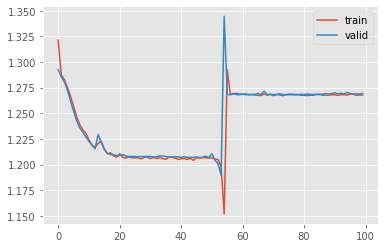

In [104]:
start = 0
plt.plot(train_loss_values[start:], label='train')
plt.plot(valid_loss_values[start:], label='valid')
plt.legend()

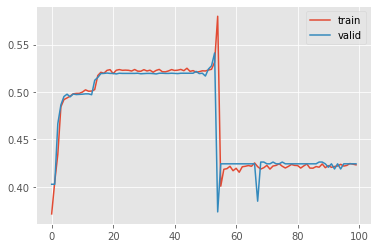

In [105]:
start = 0
plt.plot(train_accuracy_values[start:], label='train')
plt.plot(valid_accuracy_values[start:], label='valid')
plt.legend()

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [106]:
torch.save(model, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [107]:
model = torch.load('simple_nn.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)

In [108]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.values.astype(np.float32)))
print(accuracy(test_scores, torch.tensor(y_test.values.astype(np.int))).item())
print(test_scores.numpy())

0.4240553677082062
[[5.4874557e-01 1.6370996e-07 1.7375233e-04 4.5108053e-01]
 [5.4874557e-01 1.6370996e-07 1.7375233e-04 4.5108053e-01]
 [5.4874557e-01 1.6370996e-07 1.7375233e-04 4.5108053e-01]
 ...
 [5.4874557e-01 1.6370996e-07 1.7375233e-04 4.5108050e-01]
 [5.4874557e-01 1.6370996e-07 1.7375233e-04 4.5108050e-01]
 [5.4874557e-01 1.6370996e-07 1.7375233e-04 4.5108050e-01]]


In [109]:
log_loss(y_test, test_scores.numpy())

2.3174941428381985

In [111]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.values.astype(np.float32)))
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)
print(round(accuracy_score(y_test, predicted_classes), 4))

tensor([0, 0, 0,  ..., 0, 0, 0])
0.4241
